In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values.astype('float64')  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values.astype('float64')
    train_ua = train['ua'][:, :12].values.astype('float64')
    train_va = train['va'][:, :12].values.astype('float64')
    train_label = label['nino'][:, 12:36].values.astype('float64')

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values.astype('float64')  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values.astype('float64')
    train_ua2 = train2['ua'][:, :12].values.astype('float64')
    train_va2 = train2['va'][:, :12].values.astype('float64')
    train_label2 = label2['nino'][:, 12:36].values.astype('float64')
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    dict_cmip = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_soda = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4600, 45])
    train_2, valid_2 = random_split(soda_dataset, [80, 20])
    
    train_dataset = train_1 + train_2 + train_2 + train_2 + train_2 + train_2 
    valid_dataset = valid_2 + valid_1 + valid_2 + valid_2 + valid_2 + valid_2
    
    print('Train samples: {}, Valid samples: {}'.format(len(train_dataset), len(valid_dataset)))
    
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Train samples: 5000, Valid samples: 145


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.tight_layout()
        plt.show()
        
    max_score = max(score_epoch)
    max_epoch = score_epoch.index(max_score) + 1
    print("max score: {} at eopch {}".format(max_score, max_epoch))

In [10]:
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [30]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
#         resnet = models.resnet18()
#         resnet.conv1 = nn.Conv2d(48, 64, kernel_size=(4, 8), stride=(1, 1))
#         resnet.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
#         self.block = nn.Sequential(*(list((resnet).children())[:-1]))
        self.block = nn.Sequential(nn.Conv2d(48, 48, kernel_size=(4, 8), stride=(1, 1)),
                              nn.Tanh(),
                              nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
                              nn.Conv2d(48, 48, kernel_size=(2, 4), stride=(1, 1)),
                              nn.Tanh(),
                              nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
                              nn.Conv2d(48, 48, kernel_size=(2, 4), stride=(1, 1)),
                              nn.Tanh(),
                              nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
                             )
#         self.avgpool = nn.AdaptiveAvgPool2d((12,128))
        self.linear0 = nn.Linear(1584, 72)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(72, 24)

    def forward(self, sst, t300, ua, va):
        x = torch.cat((sst, t300, ua, va), dim=1)
        x = self.block(x)
        
        bs = x.shape[0]
#         x = self.avgpool(x).squeeze(dim=-2)
#         x = torch.flatten(x, start_dim=1)
        x = x.view(bs, -1)
        x = self.linear0(x)
        x = self.tanh(x)
        x = self.linear(x)
        return x

In [31]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [32]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 0.226704M


In [33]:
# model

acskill_socre:4.129485446587881, rmse_score:18.851692110293282
Epoch: 0, Valid Score: -14.7222066637054

Step: 0, Train Loss: 1.0545164346694946
Step: 20, Train Loss: 0.822026252746582
Step: 40, Train Loss: 0.7136470675468445
Step: 60, Train Loss: 0.7012828588485718
Step: 80, Train Loss: 0.662199079990387
Step: 100, Train Loss: 0.5937862992286682
Step: 120, Train Loss: 0.4371356964111328
Step: 140, Train Loss: 0.5584208965301514
Epoch: 1, Train loss: 0.58906107248774
acskill_socre:28.13593001856899, rmse_score:17.744251378731587
Epoch: 1, Valid Score: 10.391678639837401
Model saved successfully


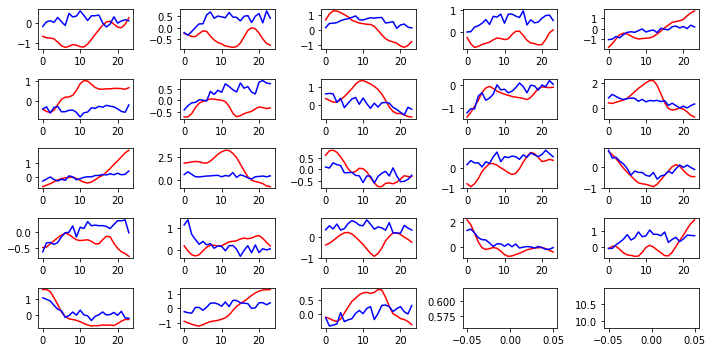

Step: 0, Train Loss: 0.4287700653076172
Step: 20, Train Loss: 0.4538273215293884
Step: 40, Train Loss: 0.554394006729126
Step: 60, Train Loss: 0.5789936184883118
Step: 80, Train Loss: 0.40707728266716003
Step: 100, Train Loss: 0.35906609892845154
Step: 120, Train Loss: 0.5094115138053894
Step: 140, Train Loss: 0.5047317743301392
Epoch: 2, Train loss: 0.48424708235795333
acskill_socre:33.38270940363696, rmse_score:16.724132137696465
Epoch: 2, Valid Score: 16.658577265940494
Model saved successfully


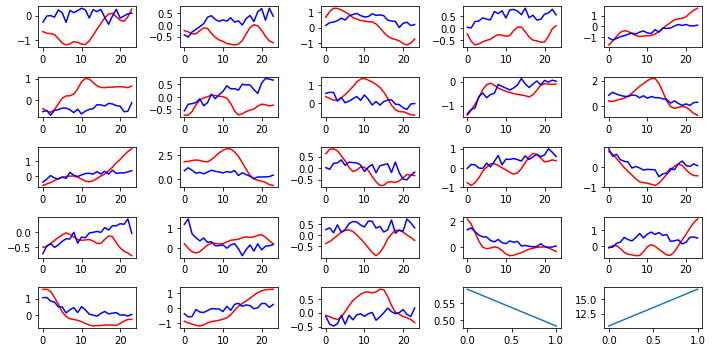

Step: 0, Train Loss: 0.47343215346336365
Step: 20, Train Loss: 0.5084787607192993
Step: 40, Train Loss: 0.3698067367076874
Step: 60, Train Loss: 0.33020249009132385
Step: 80, Train Loss: 0.5815777778625488
Step: 100, Train Loss: 0.4603464603424072
Step: 120, Train Loss: 0.41509687900543213
Step: 140, Train Loss: 0.3607194125652313
Epoch: 3, Train loss: 0.4445543671679345
acskill_socre:33.9675828314604, rmse_score:16.784558198463856
Epoch: 3, Valid Score: 17.183024632996542
Model saved successfully


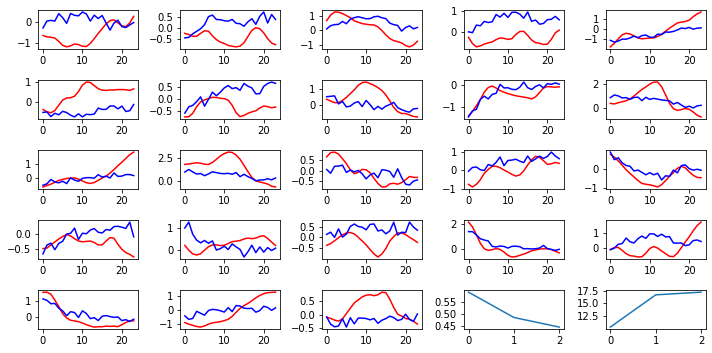

Step: 0, Train Loss: 0.3938550353050232
Step: 20, Train Loss: 0.5631017088890076
Step: 40, Train Loss: 0.34713253378868103
Step: 60, Train Loss: 0.37154000997543335
Step: 80, Train Loss: 0.42472752928733826
Step: 100, Train Loss: 0.33777469396591187
Step: 120, Train Loss: 0.44051504135131836
Step: 140, Train Loss: 0.5035265684127808
Epoch: 4, Train loss: 0.411859832182052
acskill_socre:34.275021288687064, rmse_score:16.567781502197743
Epoch: 4, Valid Score: 17.70723978648932
Model saved successfully


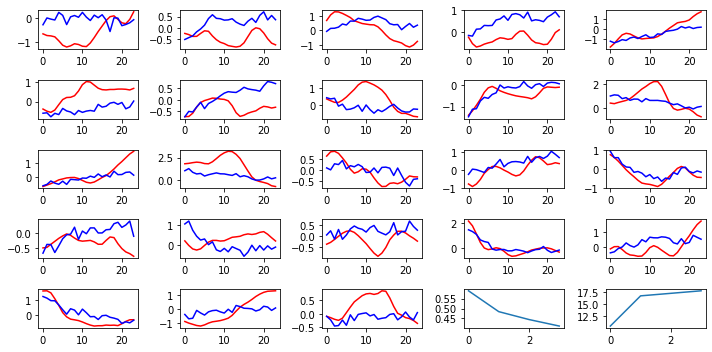

Step: 0, Train Loss: 0.43443167209625244
Step: 20, Train Loss: 0.43116313219070435
Step: 40, Train Loss: 0.3549641966819763
Step: 60, Train Loss: 0.3261471390724182
Step: 80, Train Loss: 0.3367025852203369
Step: 100, Train Loss: 0.4295666217803955
Step: 120, Train Loss: 0.4224281311035156
Step: 140, Train Loss: 0.3201475143432617
Epoch: 5, Train loss: 0.3708858078072785
acskill_socre:40.086573216430935, rmse_score:16.216873305638508
Epoch: 5, Valid Score: 23.869699910792427
Model saved successfully


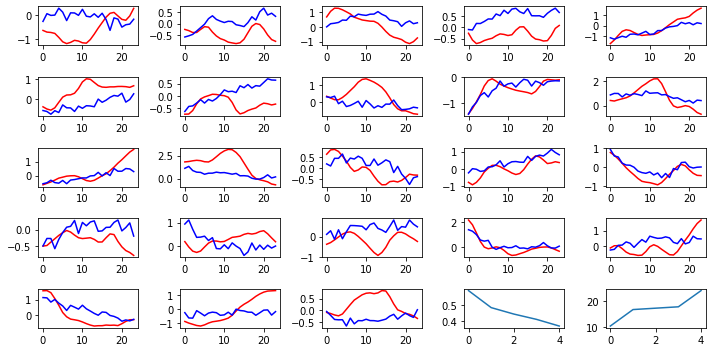

Step: 0, Train Loss: 0.3607674539089203
Step: 20, Train Loss: 0.33778977394104004
Step: 40, Train Loss: 0.3326125741004944
Step: 60, Train Loss: 0.3941403031349182
Step: 80, Train Loss: 0.2514742612838745
Step: 100, Train Loss: 0.3958582878112793
Step: 120, Train Loss: 0.34366926550865173
Step: 140, Train Loss: 0.2792106866836548
Epoch: 6, Train loss: 0.3339666275271944
acskill_socre:38.16996202426108, rmse_score:16.739282183325432
Epoch: 6, Valid Score: 21.43067984093565


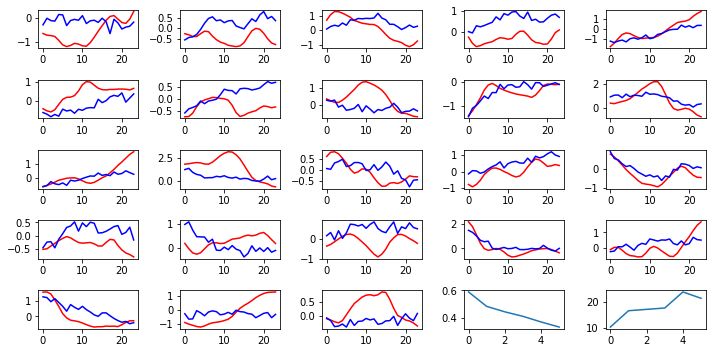

Step: 0, Train Loss: 0.2988850474357605
Step: 20, Train Loss: 0.3436247706413269
Step: 40, Train Loss: 0.281277596950531
Step: 60, Train Loss: 0.33299821615219116
Step: 80, Train Loss: 0.4369460940361023
Step: 100, Train Loss: 0.3605371415615082
Step: 120, Train Loss: 0.26197510957717896
Step: 140, Train Loss: 0.34110531210899353
Epoch: 7, Train loss: 0.29348007081800204
acskill_socre:41.91675556313723, rmse_score:16.59200934326494
Epoch: 7, Valid Score: 25.32474621987229
Model saved successfully


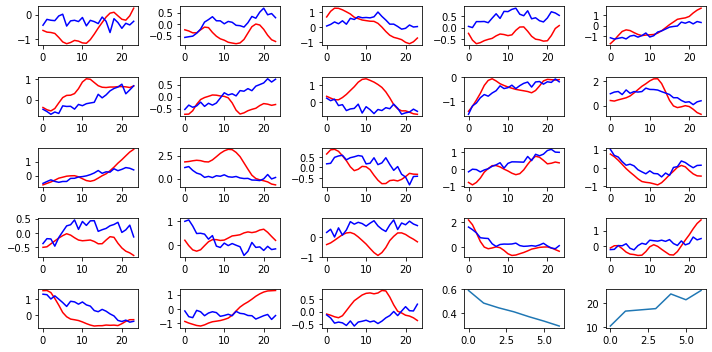

Step: 0, Train Loss: 0.2422420084476471
Step: 20, Train Loss: 0.22816704213619232
Step: 40, Train Loss: 0.24059519171714783
Step: 60, Train Loss: 0.20770573616027832
Step: 80, Train Loss: 0.2897261083126068
Step: 100, Train Loss: 0.2763479948043823
Step: 120, Train Loss: 0.2624036967754364
Step: 140, Train Loss: 0.31421393156051636
Epoch: 8, Train loss: 0.25672061399669405
acskill_socre:38.46884131802952, rmse_score:16.98194008744639
Epoch: 8, Valid Score: 21.48690123058313


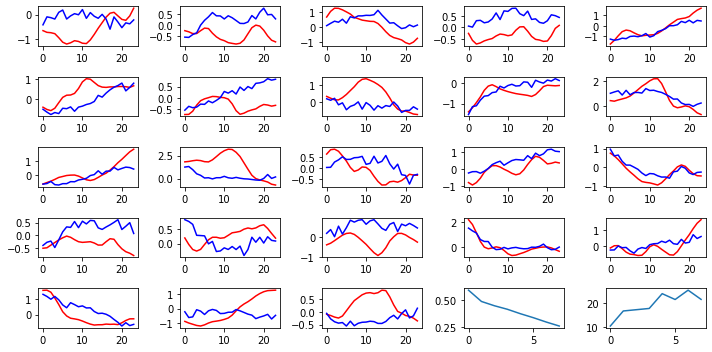

Step: 0, Train Loss: 0.2370302677154541
Step: 20, Train Loss: 0.2315618097782135
Step: 40, Train Loss: 0.1800859421491623
Step: 60, Train Loss: 0.21731798350811005
Step: 80, Train Loss: 0.2509852647781372
Step: 100, Train Loss: 0.21119599044322968
Step: 120, Train Loss: 0.27776357531547546
Step: 140, Train Loss: 0.23498353362083435
Epoch: 9, Train loss: 0.22098778254666906
acskill_socre:41.9035325666255, rmse_score:16.69564177567641
Epoch: 9, Valid Score: 25.20789079094909


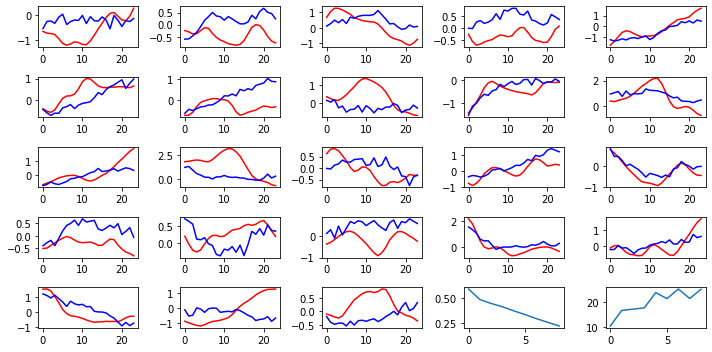

Step: 0, Train Loss: 0.20006689429283142
Step: 20, Train Loss: 0.21954552829265594
Step: 40, Train Loss: 0.17106172442436218
Step: 60, Train Loss: 0.16334351897239685
Step: 80, Train Loss: 0.21134154498577118
Step: 100, Train Loss: 0.21251332759857178
Step: 120, Train Loss: 0.16465267539024353
Step: 140, Train Loss: 0.151656836271286
Epoch: 10, Train loss: 0.1866892280567224
acskill_socre:38.99933984212998, rmse_score:17.271762535554046
Epoch: 10, Valid Score: 21.72757730657593


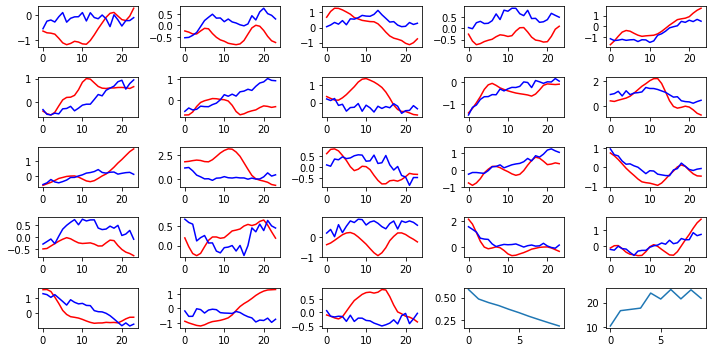

Step: 0, Train Loss: 0.15106312930583954
Step: 20, Train Loss: 0.15338896214962006
Step: 40, Train Loss: 0.1046062707901001
Step: 60, Train Loss: 0.12836095690727234
Step: 80, Train Loss: 0.1405489593744278
Step: 100, Train Loss: 0.18487748503684998
Step: 120, Train Loss: 0.12931916117668152
Step: 140, Train Loss: 0.1524127721786499
Epoch: 11, Train loss: 0.15874868545942245
acskill_socre:38.6816442691227, rmse_score:17.44070550049267
Epoch: 11, Valid Score: 21.24093876863003


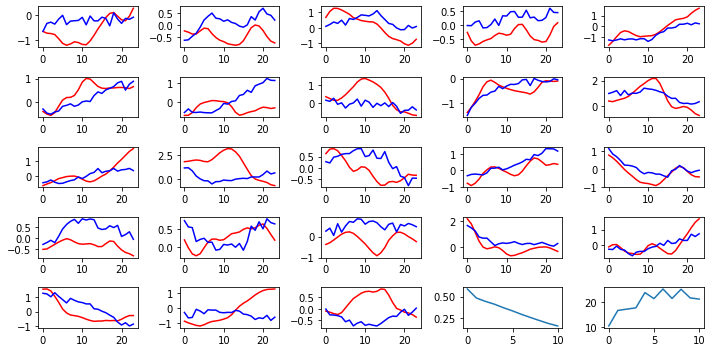

Step: 0, Train Loss: 0.13805605471134186
Step: 20, Train Loss: 0.171108216047287
Step: 40, Train Loss: 0.08062118291854858
Step: 60, Train Loss: 0.14962846040725708
Step: 80, Train Loss: 0.1386892944574356
Step: 100, Train Loss: 0.12057774513959885
Step: 120, Train Loss: 0.13213780522346497
Step: 140, Train Loss: 0.14480507373809814
Epoch: 12, Train loss: 0.13652814625744608
acskill_socre:37.791154744365045, rmse_score:17.58967948388003
Epoch: 12, Valid Score: 20.201475260485015


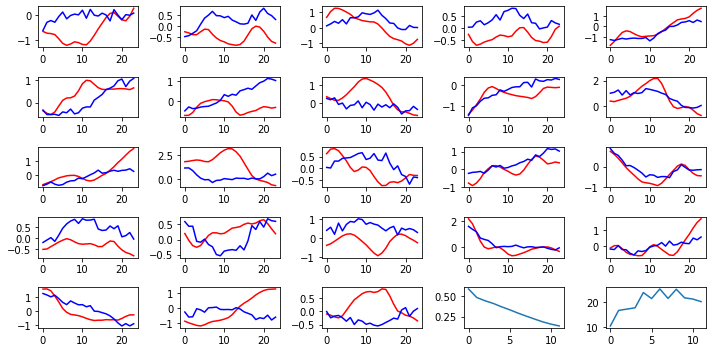

Step: 0, Train Loss: 0.0874171257019043
Step: 20, Train Loss: 0.1072467491030693
Step: 40, Train Loss: 0.1147378534078598
Step: 60, Train Loss: 0.0946665108203888
Step: 80, Train Loss: 0.12740638852119446
Step: 100, Train Loss: 0.12828969955444336
Step: 120, Train Loss: 0.11102806031703949
Step: 140, Train Loss: 0.09977912902832031
Epoch: 13, Train loss: 0.11665844105801006
acskill_socre:34.925711995183946, rmse_score:17.995443574215813
Epoch: 13, Valid Score: 16.930268420968133


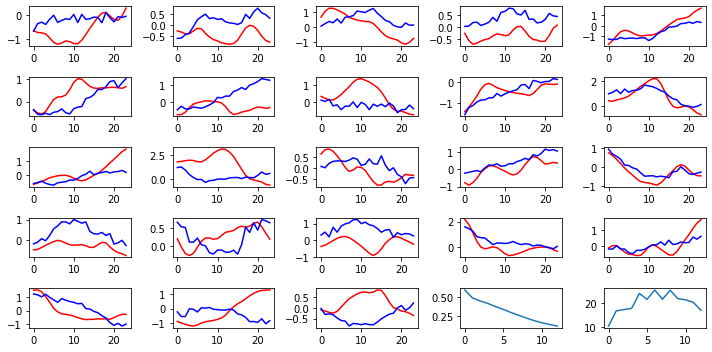

Step: 0, Train Loss: 0.09643404185771942
Step: 20, Train Loss: 0.076998770236969
Step: 40, Train Loss: 0.10680273175239563
Step: 60, Train Loss: 0.10638043284416199
Step: 80, Train Loss: 0.09045541286468506
Step: 100, Train Loss: 0.08036705106496811
Step: 120, Train Loss: 0.11032234132289886
Step: 140, Train Loss: 0.12383437156677246
Epoch: 14, Train loss: 0.10135467953173219
acskill_socre:36.21207440638428, rmse_score:17.953104414371264
Epoch: 14, Valid Score: 18.258969992013018


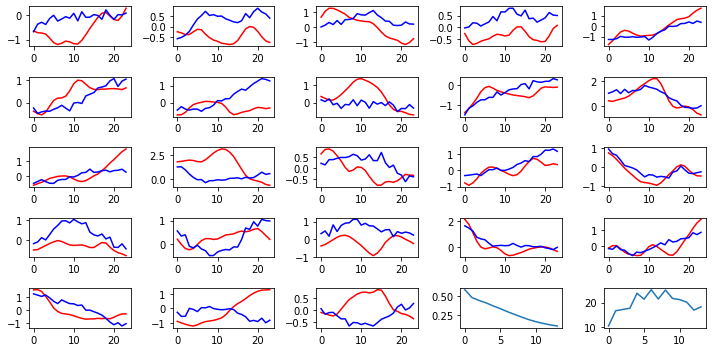

Step: 0, Train Loss: 0.08434164524078369
Step: 20, Train Loss: 0.07366710901260376
Step: 40, Train Loss: 0.06862680613994598
Step: 60, Train Loss: 0.07569548487663269
Step: 80, Train Loss: 0.0854036808013916
Step: 100, Train Loss: 0.07566019147634506
Step: 120, Train Loss: 0.11010843515396118
Step: 140, Train Loss: 0.1022358238697052
Epoch: 15, Train loss: 0.08908450133671426
acskill_socre:35.968484315393766, rmse_score:18.282057411243017
Epoch: 15, Valid Score: 17.68642690415075


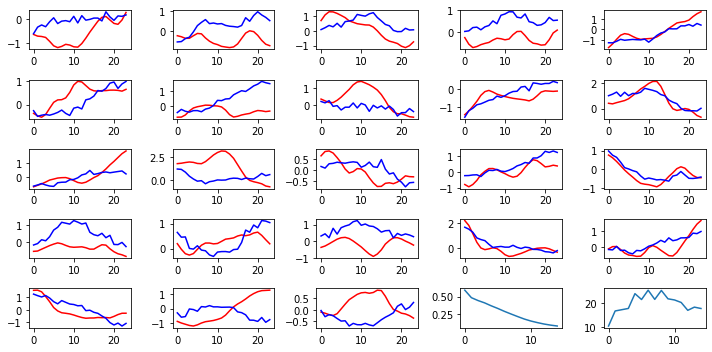

Step: 0, Train Loss: 0.07982811331748962
Step: 20, Train Loss: 0.0651785135269165
Step: 40, Train Loss: 0.07963581383228302
Step: 60, Train Loss: 0.07841761410236359
Step: 80, Train Loss: 0.07815039157867432
Step: 100, Train Loss: 0.07423585653305054
Step: 120, Train Loss: 0.06648172438144684
Step: 140, Train Loss: 0.06912068277597427
Epoch: 16, Train loss: 0.07850568110396149
acskill_socre:35.20315952579854, rmse_score:18.34747466545247
Epoch: 16, Valid Score: 16.85568486034607


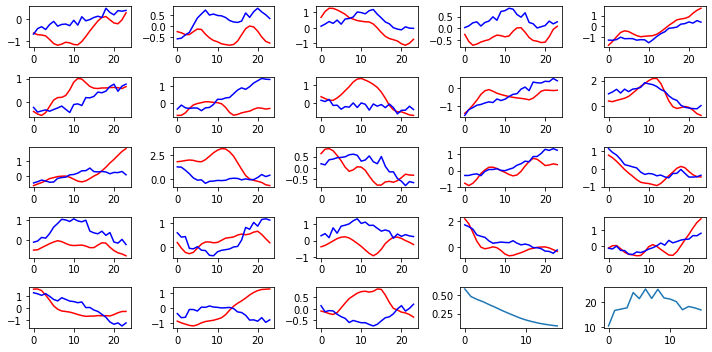

Step: 0, Train Loss: 0.08441612124443054
Step: 20, Train Loss: 0.051266562193632126
Step: 40, Train Loss: 0.061605773866176605
Step: 60, Train Loss: 0.07237940281629562
Step: 80, Train Loss: 0.06694788485765457
Step: 100, Train Loss: 0.08257246017456055
Step: 120, Train Loss: 0.07779823243618011
Step: 140, Train Loss: 0.08312509208917618
Epoch: 17, Train loss: 0.06977763233386028
acskill_socre:34.88885408204499, rmse_score:18.245928676836527
Epoch: 17, Valid Score: 16.642925405208466


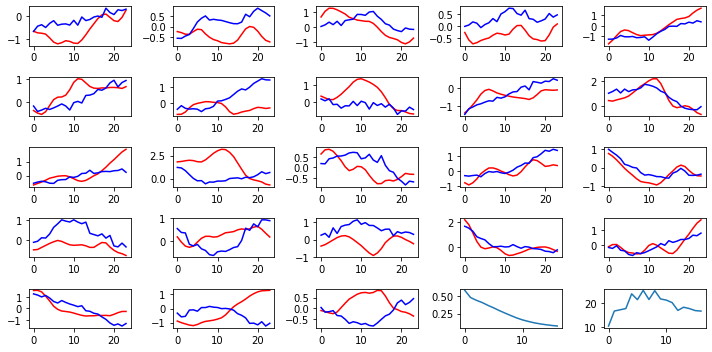

Step: 0, Train Loss: 0.07538076490163803
Step: 20, Train Loss: 0.06522519886493683
Step: 40, Train Loss: 0.06463758647441864
Step: 60, Train Loss: 0.054841991513967514
Step: 80, Train Loss: 0.06006923317909241
Step: 100, Train Loss: 0.058250121772289276
Step: 120, Train Loss: 0.053478389978408813
Step: 140, Train Loss: 0.06138724833726883
Epoch: 18, Train loss: 0.06351054362525606
acskill_socre:34.366148060930556, rmse_score:18.68451665193747
Epoch: 18, Valid Score: 15.681631408993084


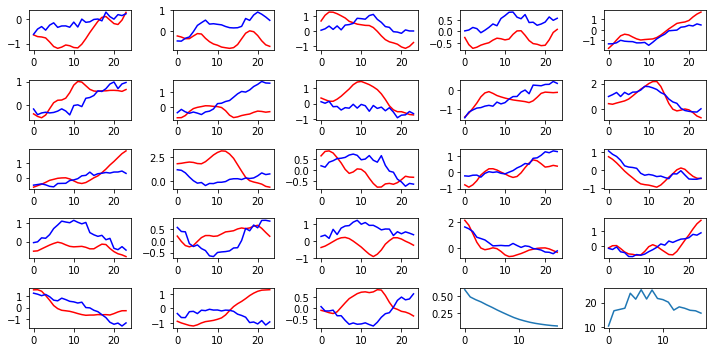

Step: 0, Train Loss: 0.0392589196562767
Step: 20, Train Loss: 0.04574243351817131
Step: 40, Train Loss: 0.04799714684486389
Step: 60, Train Loss: 0.058562152087688446
Step: 80, Train Loss: 0.04134301841259003
Step: 100, Train Loss: 0.05596895143389702
Step: 120, Train Loss: 0.07759417593479156
Step: 140, Train Loss: 0.06200312823057175
Epoch: 19, Train loss: 0.058051962880002465
acskill_socre:33.772701886170154, rmse_score:18.53093121686077
Epoch: 19, Valid Score: 15.241770669309386


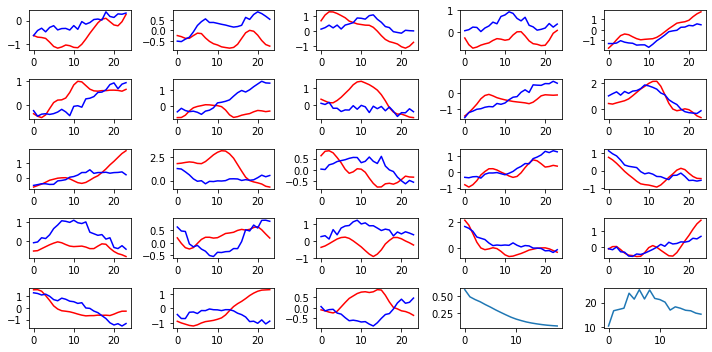

Step: 0, Train Loss: 0.052479129284620285
Step: 20, Train Loss: 0.07075253129005432
Step: 40, Train Loss: 0.05298043414950371
Step: 60, Train Loss: 0.058003075420856476
Step: 80, Train Loss: 0.051159702241420746
Step: 100, Train Loss: 0.06842027604579926
Step: 120, Train Loss: 0.0654165968298912
Step: 140, Train Loss: 0.05959477648139
Epoch: 20, Train loss: 0.05337044254989381
acskill_socre:33.24904671450205, rmse_score:18.801404742291545
Epoch: 20, Valid Score: 14.447641972210505


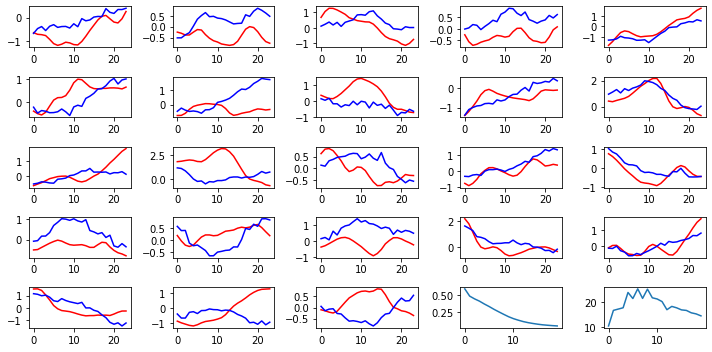

Step: 0, Train Loss: 0.060367658734321594
Step: 20, Train Loss: 0.04788919910788536
Step: 40, Train Loss: 0.04237035661935806
Step: 60, Train Loss: 0.04544252157211304
Step: 80, Train Loss: 0.033274710178375244
Step: 100, Train Loss: 0.04774685949087143
Step: 120, Train Loss: 0.04005808383226395
Step: 140, Train Loss: 0.0456455759704113
Epoch: 21, Train loss: 0.04982757808011808
acskill_socre:33.50881534376174, rmse_score:18.63416271035762
Epoch: 21, Valid Score: 14.874652633404118


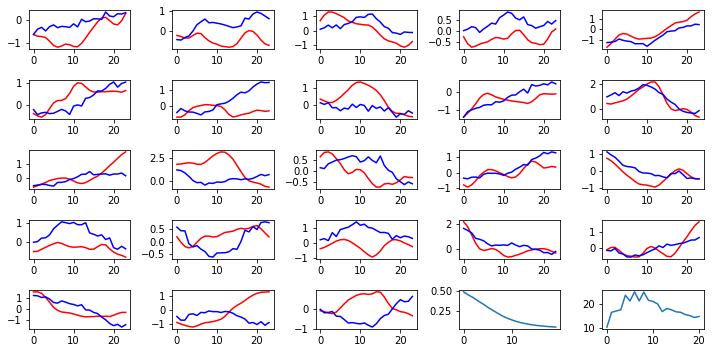

Step: 0, Train Loss: 0.04387733340263367
Step: 20, Train Loss: 0.040330566465854645
Step: 40, Train Loss: 0.05246537923812866
Step: 60, Train Loss: 0.04142889007925987
Step: 80, Train Loss: 0.05025169253349304
Step: 100, Train Loss: 0.052566271275281906
Step: 120, Train Loss: 0.04536709934473038
Step: 140, Train Loss: 0.046325426548719406
Epoch: 22, Train loss: 0.04677104622505273
acskill_socre:32.76416805337951, rmse_score:18.71074945469923
Epoch: 22, Valid Score: 14.053418598680278


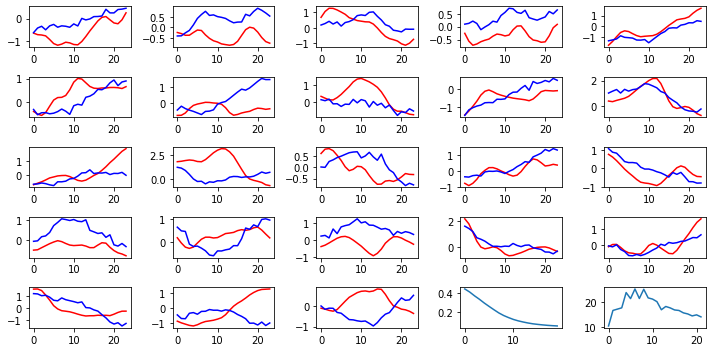

Step: 0, Train Loss: 0.03646129369735718
Step: 20, Train Loss: 0.04898257181048393
Step: 40, Train Loss: 0.03160367161035538
Step: 60, Train Loss: 0.04106387123465538
Step: 80, Train Loss: 0.045594941824674606
Step: 100, Train Loss: 0.03782397136092186
Step: 120, Train Loss: 0.06266404688358307
Step: 140, Train Loss: 0.03903523087501526
Epoch: 23, Train loss: 0.04479665833578748
acskill_socre:33.499001188257736, rmse_score:18.84153789614124
Epoch: 23, Valid Score: 14.657463292116496


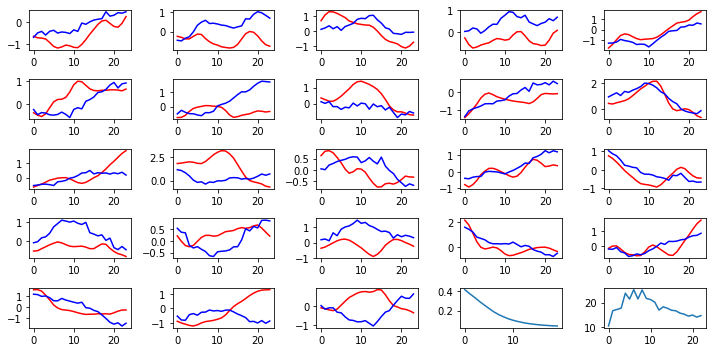

Step: 0, Train Loss: 0.05530782788991928
Step: 20, Train Loss: 0.04473275691270828
Step: 40, Train Loss: 0.04608567804098129
Step: 60, Train Loss: 0.03594405949115753
Step: 80, Train Loss: 0.042744241654872894
Step: 100, Train Loss: 0.04180886968970299
Step: 120, Train Loss: 0.037682969123125076
Step: 140, Train Loss: 0.05233504995703697
Epoch: 24, Train loss: 0.04268856090345201
acskill_socre:34.822267577075685, rmse_score:18.473580541319002
Epoch: 24, Valid Score: 16.348687035756683


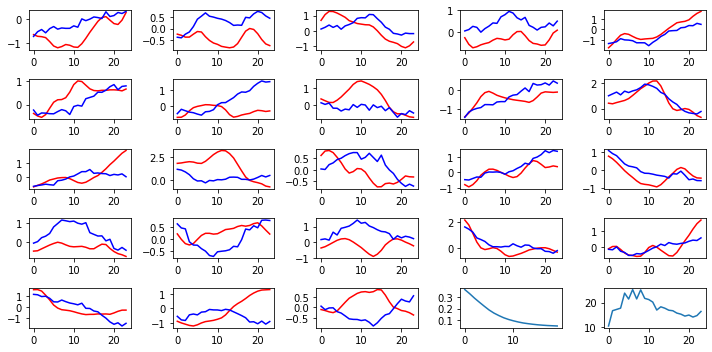

Step: 0, Train Loss: 0.03851865231990814
Step: 20, Train Loss: 0.03944777697324753
Step: 40, Train Loss: 0.03410699963569641
Step: 60, Train Loss: 0.04260372370481491
Step: 80, Train Loss: 0.042268335819244385
Step: 100, Train Loss: 0.033211927860975266
Step: 120, Train Loss: 0.038467537611722946
Step: 140, Train Loss: 0.0433560386300087
Epoch: 25, Train loss: 0.040199238059532114
acskill_socre:33.22769023246472, rmse_score:18.75930959928283
Epoch: 25, Valid Score: 14.468380633181887


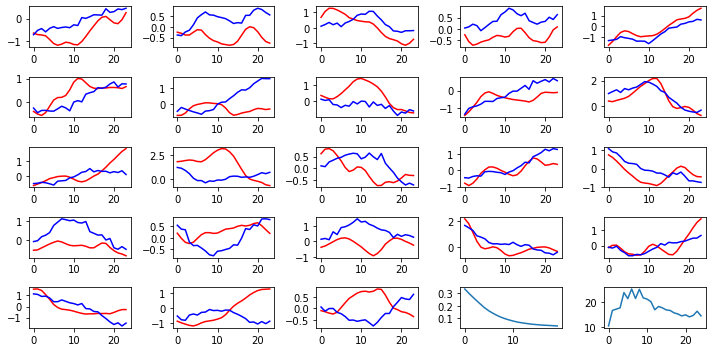

Step: 0, Train Loss: 0.0369497649371624
Step: 20, Train Loss: 0.040386851876974106
Step: 40, Train Loss: 0.03387631103396416
Step: 60, Train Loss: 0.04140549898147583
Step: 80, Train Loss: 0.035428237169981
Step: 100, Train Loss: 0.02941768988966942
Step: 120, Train Loss: 0.04074956476688385
Step: 140, Train Loss: 0.03578142821788788
Epoch: 26, Train loss: 0.038807680011744713
acskill_socre:33.53207313032809, rmse_score:18.838075581197977
Epoch: 26, Valid Score: 14.69399754913011


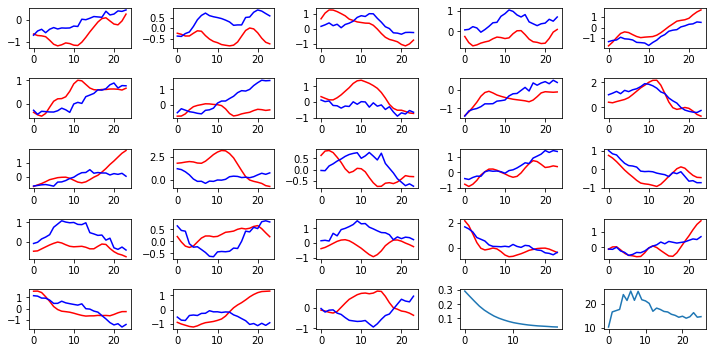

Step: 0, Train Loss: 0.03275492787361145
Step: 20, Train Loss: 0.03381366282701492
Step: 40, Train Loss: 0.032882191240787506
Step: 60, Train Loss: 0.03147634118795395
Step: 80, Train Loss: 0.03870432823896408
Step: 100, Train Loss: 0.0423521026968956
Step: 120, Train Loss: 0.04684408754110336
Step: 140, Train Loss: 0.04835543781518936
Epoch: 27, Train loss: 0.03809014635433437
acskill_socre:34.192014342568896, rmse_score:18.743886465300648
Epoch: 27, Valid Score: 15.448127877268249


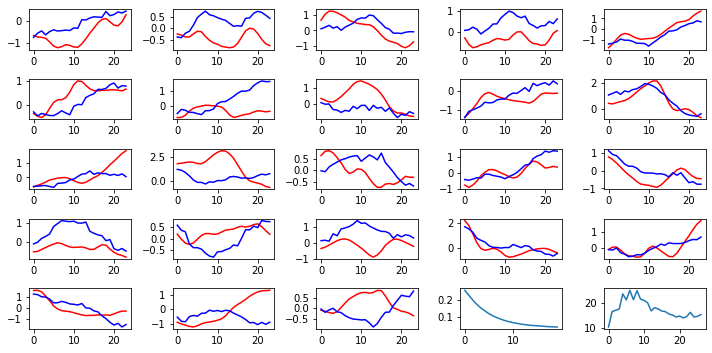

Step: 0, Train Loss: 0.035079821944236755
Step: 20, Train Loss: 0.03553358465433121
Step: 40, Train Loss: 0.03581205755472183
Step: 60, Train Loss: 0.035770103335380554
Step: 80, Train Loss: 0.0405740886926651
Step: 100, Train Loss: 0.035586751997470856
Step: 120, Train Loss: 0.03159663826227188
Step: 140, Train Loss: 0.04047746956348419
Epoch: 28, Train loss: 0.036864647428226316
acskill_socre:32.99153343988874, rmse_score:18.78540775011653
Epoch: 28, Valid Score: 14.206125689772211


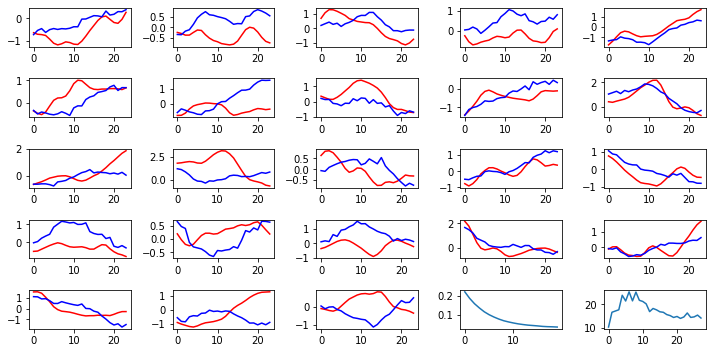

Step: 0, Train Loss: 0.029353376477956772
Step: 20, Train Loss: 0.033385805785655975
Step: 40, Train Loss: 0.03673792630434036
Step: 60, Train Loss: 0.0346892811357975
Step: 80, Train Loss: 0.03571000322699547
Step: 100, Train Loss: 0.034273114055395126
Step: 120, Train Loss: 0.034456782042980194
Step: 140, Train Loss: 0.034185443073511124
Epoch: 29, Train loss: 0.03596375582466839
acskill_socre:32.36570008260378, rmse_score:18.975802917701536
Epoch: 29, Valid Score: 13.389897164902244


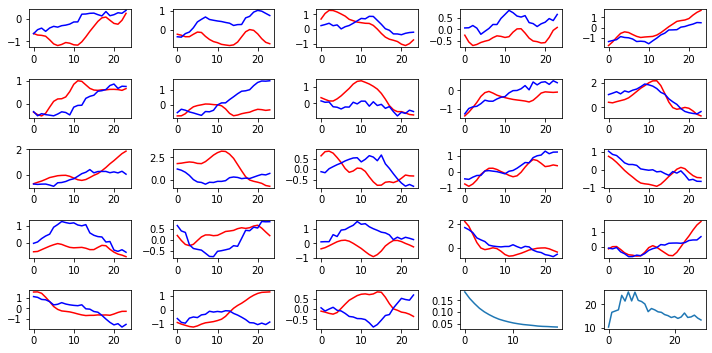

Step: 0, Train Loss: 0.03171703219413757
Step: 20, Train Loss: 0.03050297498703003
Step: 40, Train Loss: 0.03463754430413246
Step: 60, Train Loss: 0.03722696751356125
Step: 80, Train Loss: 0.03478628024458885
Step: 100, Train Loss: 0.03094886615872383
Step: 120, Train Loss: 0.04705851525068283
Step: 140, Train Loss: 0.03329819068312645
Epoch: 30, Train loss: 0.03426113722335761
acskill_socre:34.201926252940154, rmse_score:18.63610170060431
Epoch: 30, Valid Score: 15.565824552335844


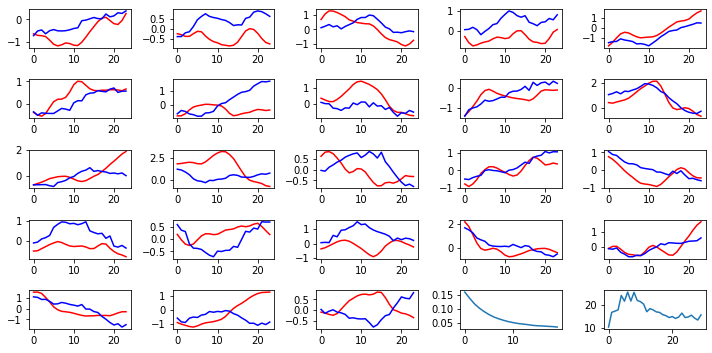

Step: 0, Train Loss: 0.03814537823200226
Step: 20, Train Loss: 0.031242549419403076
Step: 40, Train Loss: 0.027754880487918854
Step: 60, Train Loss: 0.03804539144039154
Step: 80, Train Loss: 0.036686088889837265
Step: 100, Train Loss: 0.03460565209388733
Step: 120, Train Loss: 0.03387872129678726
Step: 140, Train Loss: 0.03505917638540268
Epoch: 31, Train loss: 0.03321544919756188
acskill_socre:32.24679739719639, rmse_score:18.6982708988937
Epoch: 31, Valid Score: 13.548526498302689


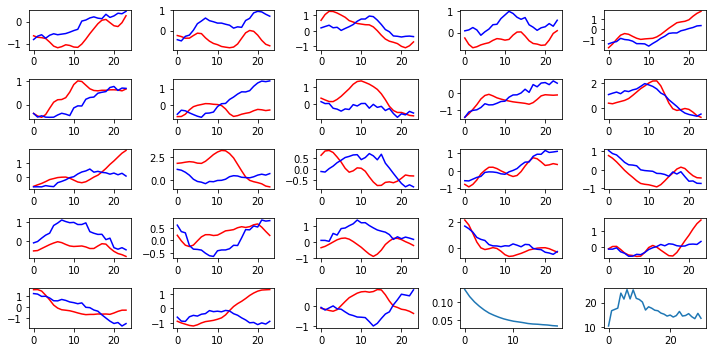

Step: 0, Train Loss: 0.026579808443784714
Step: 20, Train Loss: 0.03696373850107193
Step: 40, Train Loss: 0.030154934152960777
Step: 60, Train Loss: 0.03255533427000046
Step: 80, Train Loss: 0.029307767748832703
Step: 100, Train Loss: 0.030768942087888718
Step: 120, Train Loss: 0.0340435653924942
Step: 140, Train Loss: 0.03421720489859581
Epoch: 32, Train loss: 0.032206762641383585
acskill_socre:32.86842363674732, rmse_score:18.81739085210199
Epoch: 32, Valid Score: 14.051032784645333


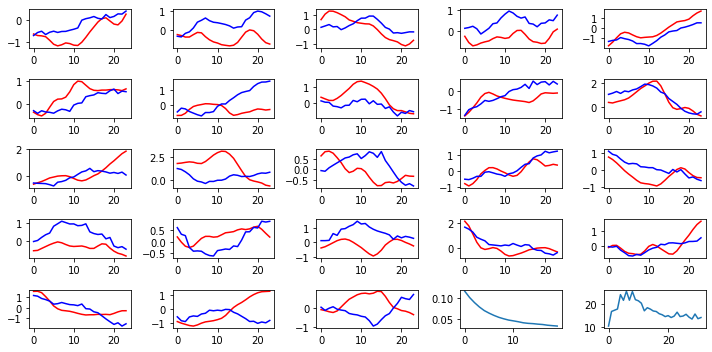

Step: 0, Train Loss: 0.02876754105091095
Step: 20, Train Loss: 0.02693088725209236
Step: 40, Train Loss: 0.03170386701822281
Step: 60, Train Loss: 0.027323251590132713
Step: 80, Train Loss: 0.03164872154593468
Step: 100, Train Loss: 0.03521724045276642
Step: 120, Train Loss: 0.03152504563331604
Step: 140, Train Loss: 0.03696618974208832
Epoch: 33, Train loss: 0.03150389758739502
acskill_socre:32.48186882157594, rmse_score:18.92130279975665
Epoch: 33, Valid Score: 13.560566021819287


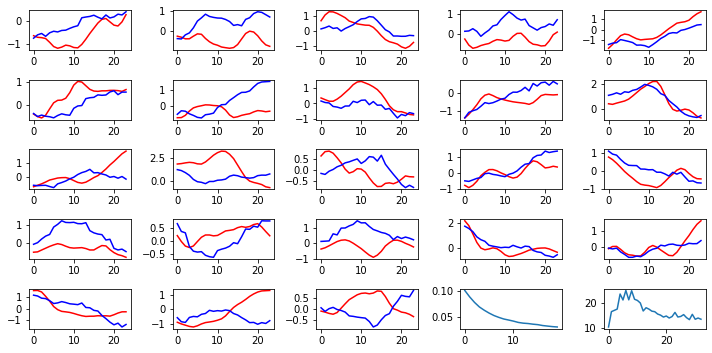

Step: 0, Train Loss: 0.03190682455897331
Step: 20, Train Loss: 0.029893314465880394
Step: 40, Train Loss: 0.02684066817164421
Step: 60, Train Loss: 0.031104829162359238
Step: 80, Train Loss: 0.0270644873380661
Step: 100, Train Loss: 0.030409958213567734
Step: 120, Train Loss: 0.0336076021194458
Step: 140, Train Loss: 0.027308132499456406
Epoch: 34, Train loss: 0.030252450246624887
acskill_socre:32.39792687618857, rmse_score:18.825231172336988
Epoch: 34, Valid Score: 13.572695703851583


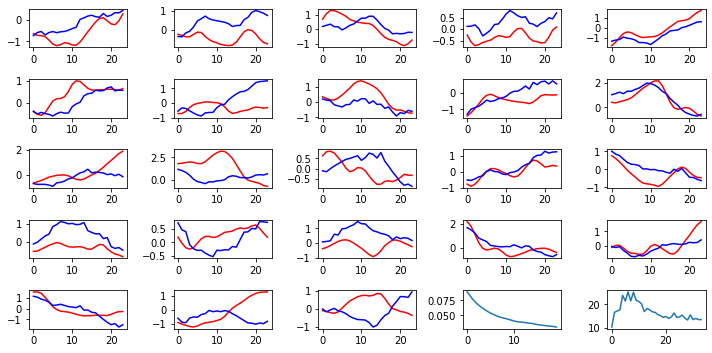

Step: 0, Train Loss: 0.031020857393741608
Step: 20, Train Loss: 0.02456418238580227
Step: 40, Train Loss: 0.029367154464125633
Step: 60, Train Loss: 0.03282324969768524
Step: 80, Train Loss: 0.032550811767578125
Step: 100, Train Loss: 0.03592679649591446
Step: 120, Train Loss: 0.028545137494802475
Step: 140, Train Loss: 0.03208210691809654
Epoch: 35, Train loss: 0.028758416213332468
acskill_socre:33.316013034609696, rmse_score:18.749606014292432
Epoch: 35, Valid Score: 14.566407020317264


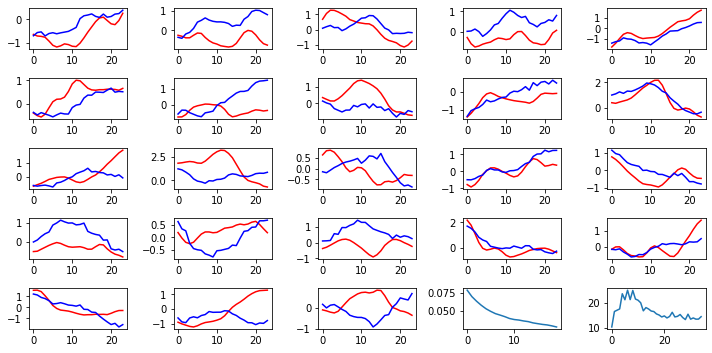

Step: 0, Train Loss: 0.02824961021542549
Step: 20, Train Loss: 0.02839275449514389
Step: 40, Train Loss: 0.02750241383910179
Step: 60, Train Loss: 0.027633115649223328
Step: 80, Train Loss: 0.025950616225600243
Step: 100, Train Loss: 0.025590797886252403
Step: 120, Train Loss: 0.022039886564016342
Step: 140, Train Loss: 0.02268061414361
Epoch: 36, Train loss: 0.027846558541534054
acskill_socre:34.254403625510335, rmse_score:18.66618752238848
Epoch: 36, Valid Score: 15.588216103121855


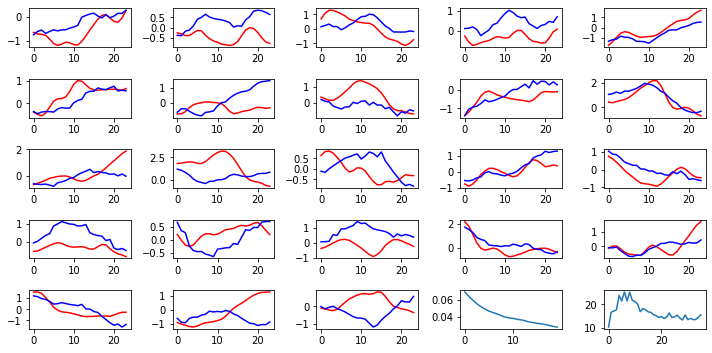

Step: 0, Train Loss: 0.026449067518115044
Step: 20, Train Loss: 0.028012461960315704
Step: 40, Train Loss: 0.02516971342265606
Step: 60, Train Loss: 0.022991865873336792
Step: 80, Train Loss: 0.02882090024650097
Step: 100, Train Loss: 0.028660085052251816
Step: 120, Train Loss: 0.021687902510166168
Step: 140, Train Loss: 0.02722769044339657
Epoch: 37, Train loss: 0.027252245990998427
acskill_socre:31.513506559428098, rmse_score:19.129747328479045
Epoch: 37, Valid Score: 12.383759230949053


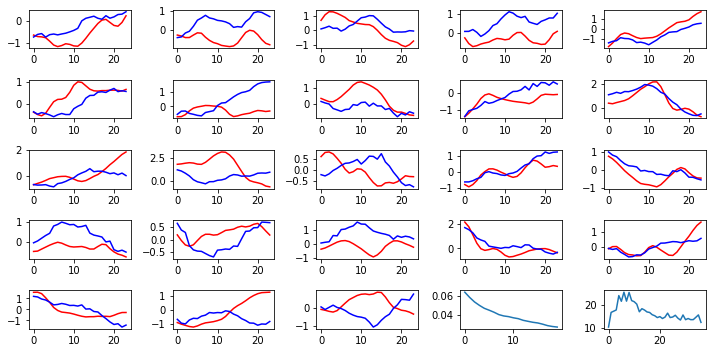

Step: 0, Train Loss: 0.031030870974063873
Step: 20, Train Loss: 0.02539912238717079
Step: 40, Train Loss: 0.03318876773118973
Step: 60, Train Loss: 0.029854293912649155
Step: 80, Train Loss: 0.024167299270629883
Step: 100, Train Loss: 0.024574851617217064
Step: 120, Train Loss: 0.02690562605857849
Step: 140, Train Loss: 0.029201868921518326
Epoch: 38, Train loss: 0.026873734227980776
acskill_socre:33.40862203691501, rmse_score:18.842789708851324
Epoch: 38, Valid Score: 14.565832328063689


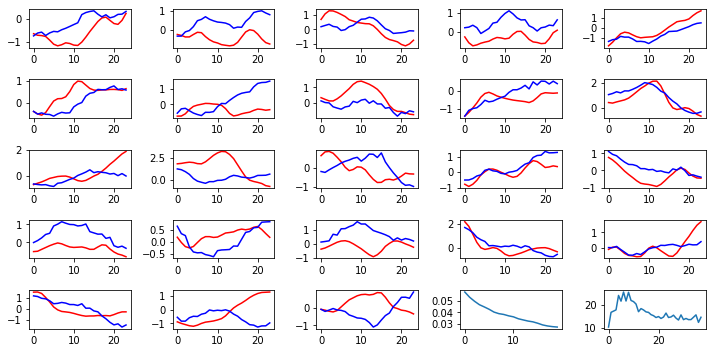

Step: 0, Train Loss: 0.025335315614938736
Step: 20, Train Loss: 0.026761066168546677
Step: 40, Train Loss: 0.027124326676130295
Step: 60, Train Loss: 0.02437470480799675
Step: 80, Train Loss: 0.02626388892531395
Step: 100, Train Loss: 0.028382346034049988
Step: 120, Train Loss: 0.026963382959365845
Step: 140, Train Loss: 0.025521691888570786
Epoch: 39, Train loss: 0.026018129210847958
acskill_socre:34.61789942491262, rmse_score:18.570534154457015
Epoch: 39, Valid Score: 16.047365270455607


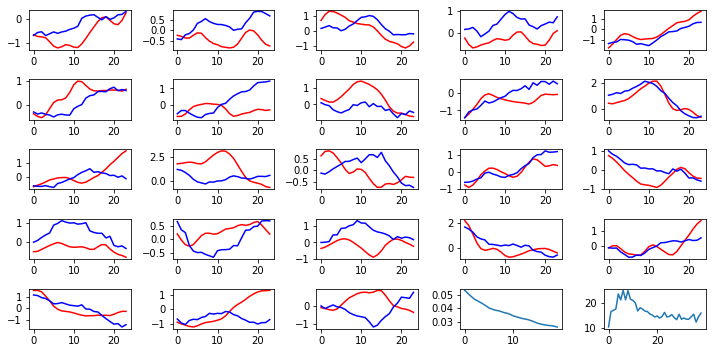

Step: 0, Train Loss: 0.021698635071516037
Step: 20, Train Loss: 0.02117079496383667
Step: 40, Train Loss: 0.026472439989447594
Step: 60, Train Loss: 0.021772680804133415
Step: 80, Train Loss: 0.028712715953588486
Step: 100, Train Loss: 0.02258768305182457
Step: 120, Train Loss: 0.02488010935485363
Step: 140, Train Loss: 0.02348407171666622
Epoch: 40, Train loss: 0.024859274933292607
acskill_socre:32.711381189618116, rmse_score:18.774763106343194
Epoch: 40, Valid Score: 13.936618083274922


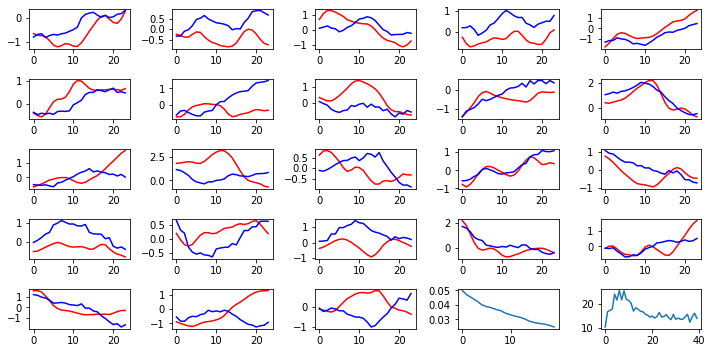

Step: 0, Train Loss: 0.02521553635597229
Step: 20, Train Loss: 0.020721804350614548
Step: 40, Train Loss: 0.02865753136575222
Step: 60, Train Loss: 0.02330559492111206
Step: 80, Train Loss: 0.023611633107066154
Step: 100, Train Loss: 0.021424472332000732
Step: 120, Train Loss: 0.02353324554860592
Step: 140, Train Loss: 0.02442125603556633
Epoch: 41, Train loss: 0.02381527858080378
acskill_socre:34.76218578776497, rmse_score:18.74772834701092
Epoch: 41, Valid Score: 16.01445744075405


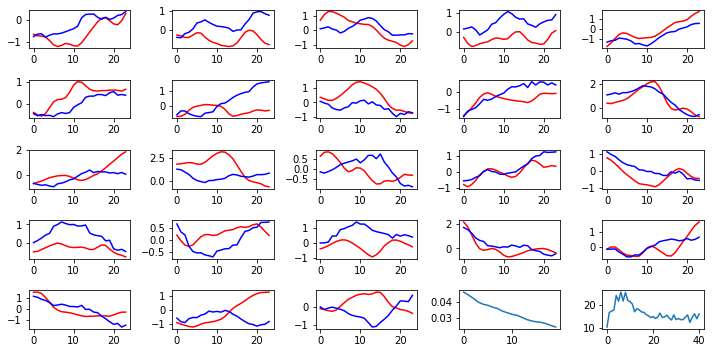

Step: 0, Train Loss: 0.02420244738459587
Step: 20, Train Loss: 0.022591397166252136
Step: 40, Train Loss: 0.020893624052405357
Step: 60, Train Loss: 0.020913755521178246
Step: 80, Train Loss: 0.024976609274744987
Step: 100, Train Loss: 0.022150341421365738
Step: 120, Train Loss: 0.02337484061717987
Step: 140, Train Loss: 0.022617455571889877
Epoch: 42, Train loss: 0.02307824897253589
acskill_socre:34.67797412544806, rmse_score:18.71858858755112
Epoch: 42, Valid Score: 15.959385537896939


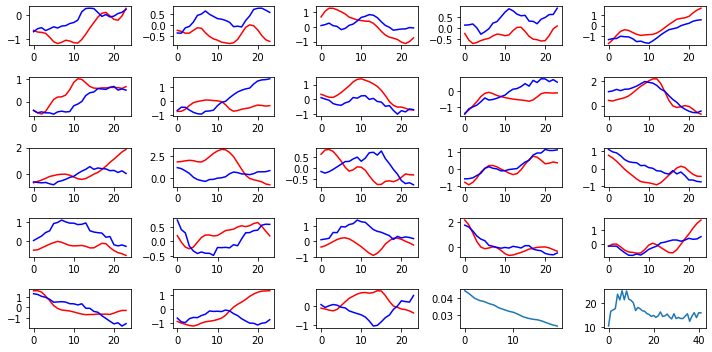

Step: 0, Train Loss: 0.020841112360358238
Step: 20, Train Loss: 0.02416691742837429
Step: 40, Train Loss: 0.023797955363988876
Step: 60, Train Loss: 0.021436095237731934
Step: 80, Train Loss: 0.01999872922897339
Step: 100, Train Loss: 0.021271755918860435
Step: 120, Train Loss: 0.02401910349726677
Step: 140, Train Loss: 0.024055084213614464
Epoch: 43, Train loss: 0.022783649349763135
acskill_socre:33.119363671378814, rmse_score:18.71372557526063
Epoch: 43, Valid Score: 14.405638096118185


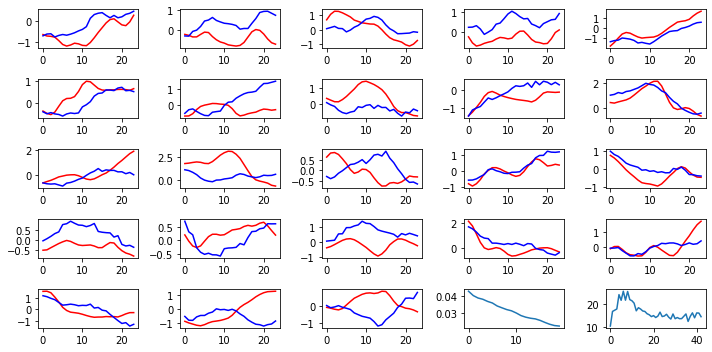

Step: 0, Train Loss: 0.0254136323928833
Step: 20, Train Loss: 0.024857794865965843
Step: 40, Train Loss: 0.02125238999724388
Step: 60, Train Loss: 0.02320379577577114
Step: 80, Train Loss: 0.02029230259358883
Step: 100, Train Loss: 0.02335389517247677
Step: 120, Train Loss: 0.02015359327197075
Step: 140, Train Loss: 0.01931411772966385
Epoch: 44, Train loss: 0.02239111298398607
acskill_socre:32.825080138913115, rmse_score:18.71456569260677
Epoch: 44, Valid Score: 14.110514446306347


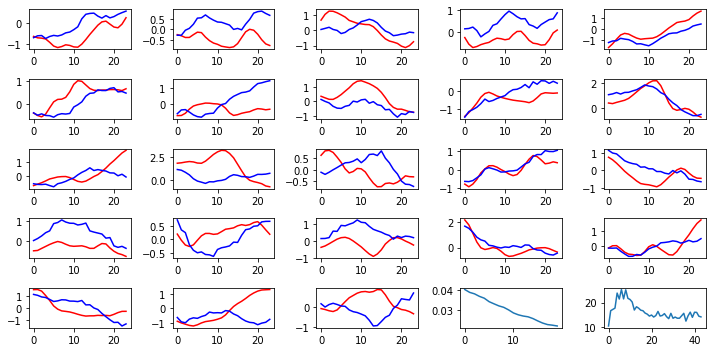

Step: 0, Train Loss: 0.021455151960253716
Step: 20, Train Loss: 0.019721686840057373
Step: 40, Train Loss: 0.019108664244413376
Step: 60, Train Loss: 0.021860063076019287
Step: 80, Train Loss: 0.021754249930381775
Step: 100, Train Loss: 0.020602677017450333
Step: 120, Train Loss: 0.02041011117398739
Step: 140, Train Loss: 0.01801413856446743
Epoch: 45, Train loss: 0.021212174254617872
acskill_socre:34.2917160248287, rmse_score:18.566922899257783
Epoch: 45, Valid Score: 15.724793125570919


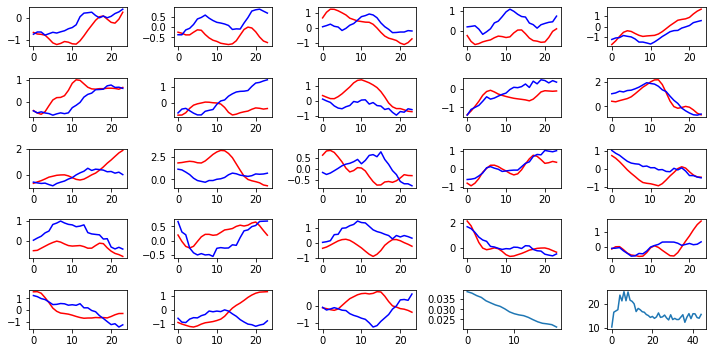

Step: 0, Train Loss: 0.01948249712586403
Step: 20, Train Loss: 0.019381623715162277
Step: 40, Train Loss: 0.018697461113333702
Step: 60, Train Loss: 0.020150519907474518
Step: 80, Train Loss: 0.02013169601559639
Step: 100, Train Loss: 0.02051490545272827
Step: 120, Train Loss: 0.022512657567858696
Step: 140, Train Loss: 0.018845459446310997
Epoch: 46, Train loss: 0.020738274238671466
acskill_socre:32.37660645622866, rmse_score:18.822344218894763
Epoch: 46, Valid Score: 13.554262237333894


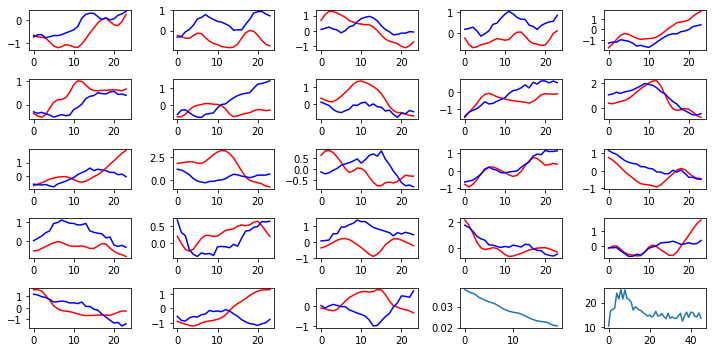

Step: 0, Train Loss: 0.01911441795527935
Step: 20, Train Loss: 0.019778702408075333
Step: 40, Train Loss: 0.021107912063598633
Step: 60, Train Loss: 0.01929100602865219
Step: 80, Train Loss: 0.021382763981819153
Step: 100, Train Loss: 0.01930597424507141
Step: 120, Train Loss: 0.019376076757907867
Step: 140, Train Loss: 0.01623031310737133
Epoch: 47, Train loss: 0.019681804427865206
acskill_socre:30.89933353880511, rmse_score:19.179579346880868
Epoch: 47, Valid Score: 11.719754191924242


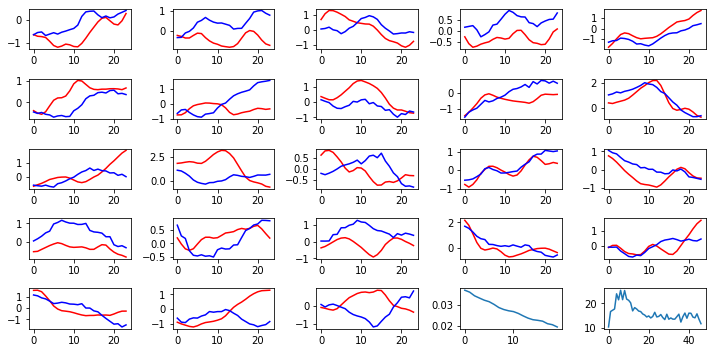

Step: 0, Train Loss: 0.022123700007796288
Step: 20, Train Loss: 0.017896777018904686
Step: 40, Train Loss: 0.019406162202358246
Step: 60, Train Loss: 0.018425345420837402
Step: 80, Train Loss: 0.01952175423502922
Step: 100, Train Loss: 0.020186131820082664
Step: 120, Train Loss: 0.020449521020054817
Step: 140, Train Loss: 0.02046959102153778
Epoch: 48, Train loss: 0.019200738104190797
acskill_socre:32.47467048485028, rmse_score:18.9824706371615
Epoch: 48, Valid Score: 13.492199847688777


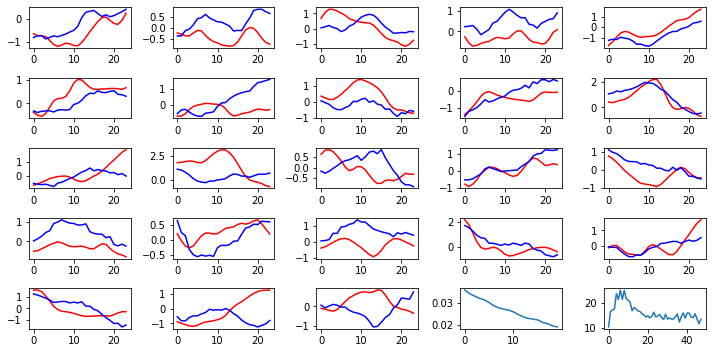

Step: 0, Train Loss: 0.017293766140937805
Step: 20, Train Loss: 0.02005469612777233
Step: 40, Train Loss: 0.0202962514013052
Step: 60, Train Loss: 0.0178874209523201
Step: 80, Train Loss: 0.01892750710248947
Step: 100, Train Loss: 0.01708230748772621
Step: 120, Train Loss: 0.019974129274487495
Step: 140, Train Loss: 0.01667775586247444
Epoch: 49, Train loss: 0.018936179459664474
acskill_socre:34.16405669166167, rmse_score:18.475030609925867
Epoch: 49, Valid Score: 15.689026081735804


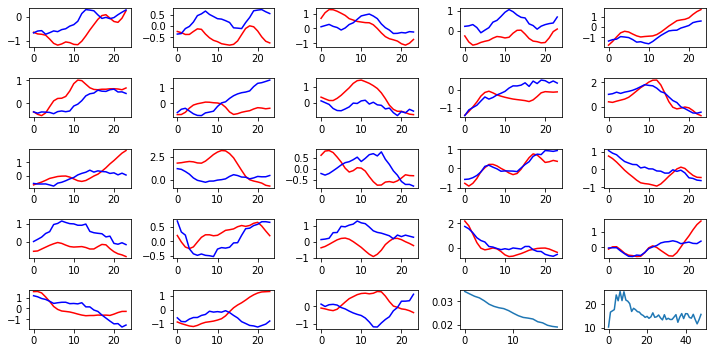

Step: 0, Train Loss: 0.016440842300653458
Step: 20, Train Loss: 0.018976811319589615
Step: 40, Train Loss: 0.018279701471328735
Step: 60, Train Loss: 0.01591349206864834
Step: 80, Train Loss: 0.02308071032166481
Step: 100, Train Loss: 0.0219135545194149
Step: 120, Train Loss: 0.020812850445508957
Step: 140, Train Loss: 0.021068384870886803
Epoch: 50, Train loss: 0.01931902849275595
acskill_socre:33.66455448055012, rmse_score:18.738180183152
Epoch: 50, Valid Score: 14.926374297398123


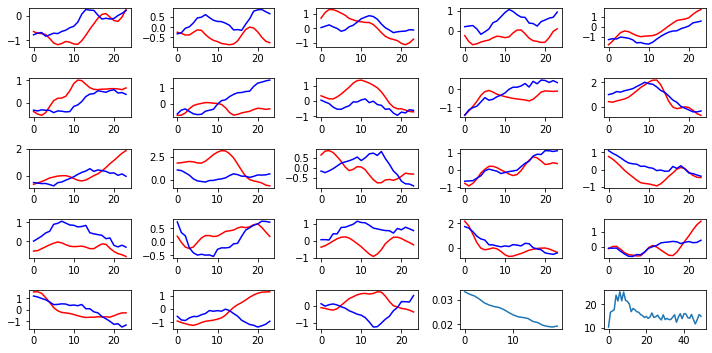

max score: 25.32474621987229 at eopch 7


In [34]:
train(num_epochs=50)

In [16]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [17]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [18]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
#     data_list = [SST,T300,Ua,Va]
#     SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

In [19]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [20]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [21]:
make_zip()